<a href="https://colab.research.google.com/github/anthai0908/Degrees-and-projects/blob/main/CNN_model_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
encoder=OneHotEncoder(sparse=False)
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Define your main folder path
main_folder = '/content/drive/MyDrive/Hnd_3000/'

# Initialize empty lists to store images and labels
images = []
labels = []

# Loop through subfolders (0-9) and load images
for label in range(10):
    subfolder_path = os.path.join(main_folder, str(label))
    for filename in os.listdir(subfolder_path):
        img_path = os.path.join(subfolder_path, filename)
        img = load_img(img_path, target_size=(28, 28))  # Adjust target_size as needed
        img_array = img_to_array(img)
        images.append(img_array)
        labels.append(label)

# Convert lists to NumPy arrays
X = np.array(images)
y = np.array(labels)

# Split the dataset into training and testing sets


X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.15, random_state=42)
X_test, X_val, y_test, y_val=train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42)
# Convert X_train to grayscale
X_train_grayscale = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in X_train])

# Convert X_test to grayscale
X_test_grayscale = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in X_test])
X_val_grayscale= np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in X_val])

# Now, you have X_train_grayscale and X_test_grayscale containing the grayscale images


In [ ]:
print(X_train_grayscale[600])

[[  0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.      ]
 [  0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.      ]
 [  0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.      ]
 [  0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.   

In [ ]:


#define convolution
class ConvLayer:
    def __init__(self, num_filters, filter_size, padding=0, stride=1):
        self.num_filters = num_filters
        self.filter_size = filter_size
        self.conv_filter = np.random.randn(num_filters, filter_size, filter_size)*(np.sqrt(2.0 / (filter_size * filter_size)))
        self.bias = np.zeros(num_filters)  # Initialize bias terms
        self.padding = padding  # Padding size
        self.stride = stride  # Stride size

    def image_region(self, image):
        height, width = image.shape
        for j in range(0, height - self.filter_size + 1, self.stride):
            for k in range(0, width - self.filter_size + 1, self.stride):
                image_patch = image[j : (j + self.filter_size), k : (k + self.filter_size)]
                yield image_patch, j, k

    def forward(self, image):
        height, width = image.shape
        padded_image = np.pad(image, ((self.padding, self.padding), (self.padding, self.padding)), mode="constant")
        self.padded_image=padded_image
        # Calculate the dimensions of the conv_out array
        output_height = (height + 2 * self.padding - self.filter_size) // self.stride + 1
        output_width = (width + 2 * self.padding - self.filter_size) // self.stride + 1

        conv_out = np.zeros((output_height, output_width, self.num_filters))

        for image_patch, i, j in self.image_region(padded_image):
            i_out = i // self.stride
            j_out = j // self.stride
            conv_out[i_out, j_out] = np.sum(image_patch * self.conv_filter, axis=(1, 2)) + self.bias  # Include bias

        return conv_out

    def backward(self, dL_dout, learning_rate):
        dL_dF_params = np.zeros(self.conv_filter.shape)
        dL_dbias = np.zeros(self.bias.shape)  # Initialize gradient for bias

        for image_patch, i, j in self.image_region(self.padded_image):
            for k in range(self.num_filters):
                dL_dF_params[k] += image_patch * dL_dout[i, j, k]
                dL_dbias[k] += dL_dout[i, j, k]

        self.conv_filter -= learning_rate * dL_dF_params
        self.bias -= learning_rate * dL_dbias  # Update bias

        return dL_dF_params, dL_dbias
#define ReLU:
class ReluLayer:
    def __init__(self):
        self.input = None

    def forward(self, input_data):
        self.input = input_data
        return np.maximum(0, input_data)

    def backward(self, dL_dout):
        dL_din = dL_dout * (self.input > 0)
        return dL_din
#define Maxpool:
class Maxpool:
    def __init__(self, filter_size=2):
        self.filter_size=filter_size
    def image_region(self,image):
        new_height=image.shape[0]//self.filter_size
        new_width=image.shape[1]//self.filter_size
        self.image=image
        for i in range(new_height):
            for j in range(new_width):
                image_patch=image[(i*self.filter_size): (i*self.filter_size+ self.filter_size), (j*self.filter_size): (j*self.filter_size+self.filter_size)]
                yield image_patch, i,j
    def forward(self, image):
        height, width, num_filters=image.shape
        output=np.zeros((height//self.filter_size, width//self.filter_size, num_filters))
        for image_patch, i,j in self.image_region(image):
            output[i,j]=np.amax(image_patch, axis=(0,1))
        return output
    def backward(self, dL_dout):
        dL_dmaxpool= np.zeros(self.image.shape)
        for image_patch,i,j in self.image_region(self.image):
            height, width, num_filters= image_patch.shape
            maximum_val=np.amax(image_patch, axis=(0,1))
            for il in range(height):
                for jl in range(width):
                    for kl in range(num_filters):
                        if image_patch[il, jl, kl]==maximum_val[kl]:
                            dL_dmaxpool[i*self.filter_size + il, j*self.filter_size+jl, kl]= dL_dout[i,j,kl]
            return dL_dmaxpool
#define Softmax
class Softmax:
    def __init__(self,input_node, softmax_node):
        self.weights=np.random.randn(input_node, softmax_node)*(np.sqrt(2.0 /input_node))
        self.biases=np.zeros(softmax_node)
    def forward(self, image):
        self.orig_im_shape=image.shape
        flattenned_value= image.flatten()
        self.modified_input=flattenned_value
        dense_val=np.dot(flattenned_value, self.weights)+ self.biases
        self.out=dense_val
        exp_out=np.exp(dense_val)
        return exp_out/np.sum(exp_out, axis=0)
    def backward(self, dL_dout, learning_rate):
        for i, grad in enumerate(dL_dout):
            if grad ==0:
                continue
            #backpropagation of softmax
            transformation_eq=np.exp(self.out)
            S_total=np.sum(transformation_eq)
            dy_dx=-transformation_eq[i]*transformation_eq/(S_total**2)
            dy_dx[i]= transformation_eq[i]*(S_total-transformation_eq[i])/(S_total**2)
            dx_dw=self.modified_input
            dx_db=1
            dx_d_inp=self.weights
            #Backpropagation of fully connected layer and parameters update
            dL_dx=grad*dy_dx
            dL_dw=dx_dw[np.newaxis].T @ dL_dx[np.newaxis]
            dL_db=dL_dx*dx_db
            dL_d_inp=dx_d_inp @ dL_dx
            self.weights-=dL_dw*learning_rate
            self.biases-=dL_db*learning_rate
            return dL_d_inp.reshape(self.orig_im_shape)#backpropagation of flattenning layer
conv=ConvLayer(16,3, padding=2, stride=1)
pool=Maxpool(2)
softmax=Softmax(3600, 10)
relu=ReluLayer()
def apply_random_data_augmentation(image):
    # Randomly select one augmentation technique to apply
    augmentation_functions = [flip_horizontal, rotate_image, translate_image, add_noise]
    chosen_augmentation = np.random.choice(augmentation_functions)

    # Apply the selected augmentation technique
    image = chosen_augmentation(image)

    # Ensure the output image size is 28x28
    image = resize_to_28x28(image)

    return image

# Function to flip the image horizontally
def flip_horizontal(image):
    return cv2.flip(image, 1)

# Function to rotate the image by a random angle between -10 and 10 degrees
def rotate_image(image):
    angle = np.random.uniform(-10, 10)
    return cv2.warpAffine(image, cv2.getRotationMatrix2D((image.shape[1] / 2, image.shape[0] / 2), angle, 1.0), (image.shape[1], image.shape[0]))

# Function to translate the image by random amounts between -5 and 5 pixels in both directions
def translate_image(image):
    dx, dy = np.random.randint(-5, 5, size=2)
    return cv2.warpAffine(image, np.float32([[1, 0, dx], [0, 1, dy]]), (image.shape[1], image.shape[0]))

# Function to resize the image to 28x28 pixels
def resize_to_28x28(image):
    return cv2.resize(image, (28, 28))

# Function to add random Gaussian noise
def add_noise(image):
    noise_level = np.random.uniform(0, 10)
    noise = np.random.normal(0, noise_level, image.shape).astype(image.dtype)  # Match data type
    noisy_image = cv2.add(image, noise)
    return noisy_image

def cnn_fordward(image, label):
    out_p=conv.forward((image/225))
    out_p = relu.forward(out_p)
    out_p=pool.forward(out_p)
    out_p= softmax.forward(out_p)
    epsilon = 1e-7
    out_p=out_p +epsilon#adding epsilon to prevent
    cross_ent_loss=-np.log(out_p[label])
    accuracy_eval=1 if np.argmax(out_p)==label else 0

    return out_p, cross_ent_loss, accuracy_eval
def training_cnn(image, label,learning_rate=.002):
    out, loss, acc = cnn_fordward(image, label)
    gradient=np.zeros(10)
    gradient[label]=-1/out[label]
    grad_back=softmax.backward(gradient, learning_rate)
    grad_back=pool.backward(grad_back)
    grad_back = relu.backward(grad_back)
    grad_back=conv.backward(grad_back, learning_rate)
    return loss, acc


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

# Lists to store train and test losses after each epoch
train_losses_epoch = []
test_losses = []
test_accuracies = []
true_labels = []
predicted_labels = []
# Training loop
for epoch in range(20):
    print('Epoch %d--->' % (epoch + 1))
    shuffle_data = np.random.permutation(len(X_train_grayscale))
    X_train_grayscale = X_train_grayscale[shuffle_data]
    y_train = y_train[shuffle_data]
    train_loss = 0
    num_correct = 0
    train_losses_batch=[]
    for i, (im, label) in enumerate(zip(X_train_grayscale, y_train)):
        augmented_image = apply_random_data_augmentation(im)
        loss, accu = training_cnn(augmented_image, label)
        train_loss += loss
        num_correct += accu
        if i % 100 == 0:
            train_loss /= 100   #calculate average train loss each batch
            train_losses_batch.append(train_loss)  # Collect train loss after each batch
            print('%d steps out of 100 steps: Average train loss %.3f and Accuracy: %d%%' % (i + 1, train_loss, num_correct))
            train_loss = 0
            num_correct = 0
    train_losses_epoch.append(sum(train_losses_batch)/len(train_losses_batch))

    print('Epoch %d: Train Loss %.3f' % (epoch + 1, train_losses_epoch[-1]))  # Print train loss after each epoch

    # Test loop (calculate test loss and accuracy)
    test_loss = 0
    num_test_correct = 0

    for i, (im, label) in enumerate(zip(X_test_grayscale, y_test)):

        _, loss, accu = cnn_fordward(im, label)
        test_loss += loss
        num_test_correct += accu
    test_losses.append(test_loss / len(X_test_grayscale))  # Collect test loss after each epoch
    test_accuracy = num_test_correct / len(X_test_grayscale)
    test_accuracies.append(test_accuracy)  # Collect test accuracy after each epoch
    print('Epoch %d: Test Loss %.3f, Test Accuracy %.2f%%' % (epoch + 1, test_losses[-1], test_accuracy * 100))

# Plot train and test losses for each epoch

for i, (im, label) in enumerate(zip(X_val_grayscale, y_val)):

        _, loss, accu = cnn_fordward(im, label)
        true_labels.append(label)
        predicted_labels.append(np.argmax(_))
# Compute and plot the confusion matrix








Epoch 1--->
1 steps out of 100 steps: Average train loss 0.026 and Accuracy: 0%
101 steps out of 100 steps: Average train loss 2.336 and Accuracy: 21%
201 steps out of 100 steps: Average train loss 1.802 and Accuracy: 44%
301 steps out of 100 steps: Average train loss 1.881 and Accuracy: 41%
401 steps out of 100 steps: Average train loss 1.626 and Accuracy: 50%
501 steps out of 100 steps: Average train loss 1.450 and Accuracy: 54%
601 steps out of 100 steps: Average train loss 1.475 and Accuracy: 55%
701 steps out of 100 steps: Average train loss 1.414 and Accuracy: 57%
801 steps out of 100 steps: Average train loss 1.191 and Accuracy: 63%
901 steps out of 100 steps: Average train loss 1.632 and Accuracy: 51%
1001 steps out of 100 steps: Average train loss 1.318 and Accuracy: 61%
1101 steps out of 100 steps: Average train loss 1.170 and Accuracy: 59%
1201 steps out of 100 steps: Average train loss 0.923 and Accuracy: 73%
1301 steps out of 100 steps: Average train loss 1.479 and Accurac

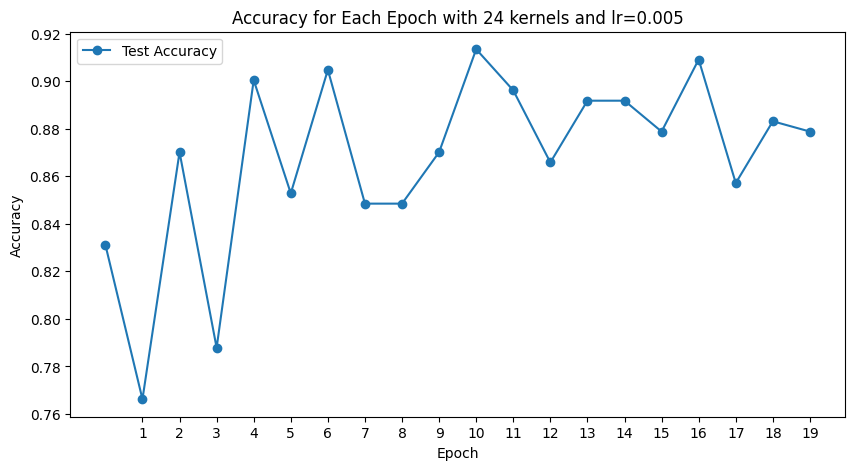

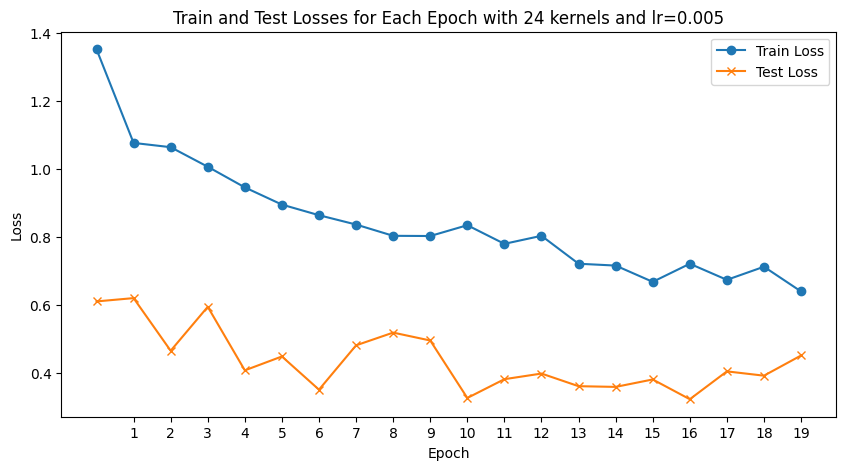

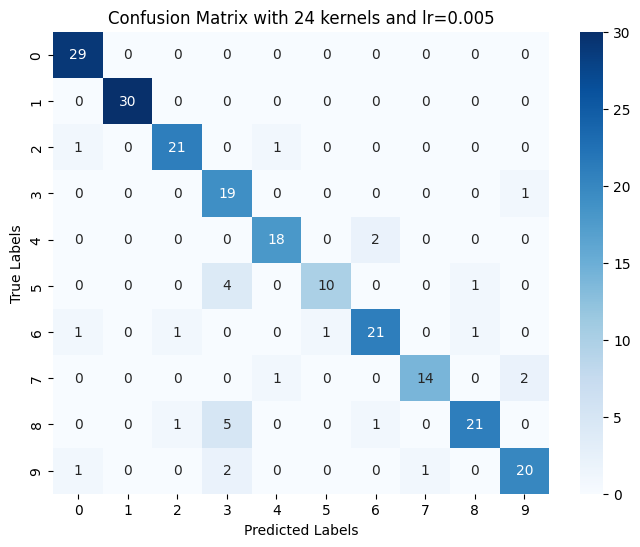

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(20), test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy for Each Epoch with 24 kernels and lr=0.005')
plt.xticks(range(1,20))
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(20), train_losses_epoch, label='Train Loss', marker='o')
plt.plot(range(20), test_losses, label='Test Loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Test Losses for Each Epoch with 24 kernels and lr=0.005')
plt.xticks(range(1,20))
plt.show()


# Compute and plot the confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=True, yticklabels=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix with 24 kernels and lr=0.005')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

accuracy = accuracy_score(true_labels, predicted_labels)
report = classification_report(true_labels, predicted_labels)
cm = confusion_matrix(true_labels, predicted_labels)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")
print(f"Confusion Matrix:\n{cm}")

Accuracy: 0.8787878787878788
Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        29
           1       1.00      1.00      1.00        30
           2       0.91      0.91      0.91        23
           3       0.63      0.95      0.76        20
           4       0.90      0.90      0.90        20
           5       0.91      0.67      0.77        15
           6       0.88      0.84      0.86        25
           7       0.93      0.82      0.87        17
           8       0.91      0.75      0.82        28
           9       0.87      0.83      0.85        24

    accuracy                           0.88       231
   macro avg       0.89      0.87      0.87       231
weighted avg       0.89      0.88      0.88       231

Confusion Matrix:
[[29  0  0  0  0  0  0  0  0  0]
 [ 0 30  0  0  0  0  0  0  0  0]
 [ 1  0 21  0  1  0  0  0  0  0]
 [ 0  0  0 19  0  0  0  0  0  1]
 [ 0  0  0  0 18  0  2  0  0  0]
 [ 0  

In [ ]:
test_losses_24_kernel_lr_0_005=test_losses.copy()
test_accuracy_24_kernel_lr_0_005=test_accuracies.copy()
print(test_losses_24_kernel_lr_0_005)
print(test_accuracy_24_kernel_lr_0_005)

[0.8361664476448855, 0.695544439032893, 0.6276429068215759, 0.5762533331686885, 0.5531988840702944, 0.5290913530493464, 0.5247451935923952, 0.5103653898027956, 0.49092746753414884, 0.466906956553103, 0.4745673678465226, 0.4396509653960807, 0.45103007037659903, 0.45008618375050946, 0.43472629300493826, 0.44025355987385556, 0.43472405501027256, 0.4331979229047639, 0.4319989124150819, 0.40954158079295017]
[0.7705627705627706, 0.8268398268398268, 0.8354978354978355, 0.8441558441558441, 0.8441558441558441, 0.8441558441558441, 0.8484848484848485, 0.8571428571428571, 0.8571428571428571, 0.8831168831168831, 0.8874458874458875, 0.8961038961038961, 0.8917748917748918, 0.8917748917748918, 0.8787878787878788, 0.8874458874458875, 0.8787878787878788, 0.8961038961038961, 0.8874458874458875, 0.9004329004329005]


test_losses_8_kernel_lr_0_001: [1.8502896146027334, 1.5331625893372685, 1.3198183859640678, 1.1825879691067103, 1.086168212739968, 1.011117330691523, 0.9494983639282415, 0.9062573398748577, 0.8632141175808065, 0.8334991977250791, 0.8059479769089951, 0.7846151880866337, 0.7591371337955126, 0.742917258085323, 0.7232249274498556, 0.710914679920135, 0.6980187287111164, 0.6830008391429521, 0.6800679544564918, 0.6654653149944715]


test_accuracy_8_kernels_lr_0_001:
[0.7056277056277056, 0.7142857142857143, 0.7705627705627706, 0.7575757575757576, 0.7835497835497836, 0.7835497835497836, 0.7965367965367965, 0.8008658008658008, 0.8181818181818182, 0.8225108225108225, 0.8138528138528138, 0.8268398268398268, 0.8311688311688312, 0.8268398268398268, 0.8268398268398268, 0.8268398268398268, 0.8268398268398268, 0.8311688311688312, 0.8311688311688312, 0.8311688311688312]
Validation Accuracy 8 kernels lr 0.001: .8658008658008658
Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.94        29
           1       0.88      1.00      0.94        30
           2       0.88      0.96      0.92        23
           3       0.68      0.75      0.71        20
           4       1.00      0.75      0.86        20
           5       0.71      0.67      0.69        15
           6       1.00      0.84      0.91        25
           7       0.85      1.00      0.92        17
           8       0.91      0.75      0.82        28
           9       0.83      0.83      0.83        24

    accuracy                           0.87       231
   macro avg       0.86      0.85      0.85       231
weighted avg       0.87      0.87      0.86       231

Confusion Matrix:
[[29  0  0  0  0  0  0  0  0  0]
 [ 0 30  0  0  0  0  0  0  0  0]
 [ 0  0 22  0  0  0  0  1  0  0]
 [ 0  0  0 15  0  2  0  1  2  0]
 [ 0  1  0  0 15  0  0  0  0  4]
 [ 1  0  0  3  0 10  0  1  0  0]
 [ 1  0  1  0  0  2 21  0  0  0]
 [ 0  0  0  0  0  0  0 17  0  0]
 [ 0  2  2  3  0  0  0  0 21  0]
 [ 2  1  0  1  0  0  0  0  0 20]]

test_losses_16_kernel_lr_0_001
[1.7483693248139804, 1.423064915494892, 1.2100203083897867, 1.0769164503161945, 0.9861756362424651, 0.9125882167903634, 0.8665710829845753, 0.8261714862926461, 0.8010690066164646, 0.7615958530547289, 0.7428779401413068, 0.7201580471665731, 0.7004004421783353, 0.6894542570166959, 0.6812233276476387, 0.6578872538318505, 0.644221293965346, 0.6361440200032893, 0.6238274705085635, 0.6241845899913184]

test_accuracy_16_kernel_lr_0_001
[0.6363636363636364, 0.7402597402597403, 0.7748917748917749, 0.7792207792207793, 0.8138528138528138, 0.8138528138528138, 0.8225108225108225, 0.8268398268398268, 0.8181818181818182, 0.8354978354978355, 0.8225108225108225, 0.8225108225108225, 0.8398268398268398, 0.8354978354978355, 0.8311688311688312, 0.8354978354978355, 0.8441558441558441, 0.8311688311688312, 0.8354978354978355, 0.8354978354978355]
Validation Accuracy: 0.8701298701298701
Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.94        29
           1       0.94      1.00      0.97        30
           2       0.92      0.96      0.94        23
           3       0.70      0.80      0.74        20
           4       0.93      0.70      0.80        20
           5       0.69      0.60      0.64        15
           6       0.96      0.88      0.92        25
           7       0.85      1.00      0.92        17
           8       0.96      0.79      0.86        28
           9       0.80      0.83      0.82        24

    accuracy                           0.87       231
   macro avg       0.86      0.86      0.85       231
weighted avg       0.87      0.87      0.87       231

Confusion Matrix:
[[29  0  0  0  0  0  0  0  0  0]
 [ 0 30  0  0  0  0  0  0  0  0]
 [ 0  0 22  0  0  0  0  1  0  0]
 [ 0  0  0 16  0  2  0  1  1  0]
 [ 0  0  0  0 14  0  1  0  0  5]
 [ 1  0  0  3  1  9  0  1  0  0]
 [ 1  0  0  0  0  2 22  0  0  0]
 [ 0  0  0  0  0  0  0 17  0  0]
 [ 0  1  2  3  0  0  0  0 22  0]
 [ 2  1  0  1  0  0  0  0  0 20]]

test_losses_24_kernel_lr_0_001
[1.158811717838892, 0.8961624889675455, 0.7838185444069777, 0.7229840786129569, 0.6721797966201175, 0.6733884724421887, 0.6185660580220251, 0.60173282150258, 0.5888755100593802, 0.5764705296794577, 0.5645168491156024, 0.5559571084811554, 0.5553652664975224, 0.5516976671647856, 0.5586324498153142, 0.5336410082057482, 0.526418025463597, 0.5497787223226636, 0.5404544378377245, 0.5155087768115182]


test_accuracy_24_kernel_lr_0_001
[0.7922077922077922, 0.7922077922077922, 0.8311688311688312, 0.8138528138528138, 0.8268398268398268, 0.8311688311688312, 0.8441558441558441, 0.8441558441558441, 0.8528138528138528, 0.8528138528138528, 0.8441558441558441, 0.8571428571428571, 0.8484848484848485, 0.8528138528138528, 0.8528138528138528, 0.8571428571428571, 0.8614718614718615, 0.8571428571428571, 0.8614718614718615, 0.8571428571428571]
Accuracy: 0.8831168831168831
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        29
           1       0.91      1.00      0.95        30
           2       0.85      0.96      0.90        23
           3       0.75      0.75      0.75        20
           4       0.84      0.80      0.82        20
           5       0.73      0.73      0.73        15
           6       1.00      0.84      0.91        25
           7       0.84      0.94      0.89        17
           8       0.96      0.86      0.91        28
           9       0.91      0.83      0.87        24

    accuracy                           0.88       231
   macro avg       0.87      0.87      0.87       231
weighted avg       0.89      0.88      0.88       231

Confusion Matrix:
[[29  0  0  0  0  0  0  0  0  0]
 [ 0 30  0  0  0  0  0  0  0  0]
 [ 0  0 22  0  0  0  0  1  0  0]
 [ 0  0  1 15  0  2  0  1  1  0]
 [ 0  2  0  0 16  0  0  0  0  2]
 [ 0  0  0  2  1 11  0  1  0  0]
 [ 1  0  1  0  0  2 21  0  0  0]
 [ 0  0  0  0  1  0  0 16  0  0]
 [ 0  0  2  2  0  0  0  0 24  0]
 [ 1  1  0  1  1  0  0  0  0 20]]

 test_losses_24_kernel_lr_0_005
[0.8361664476448855, 0.695544439032893, 0.6276429068215759, 0.5762533331686885, 0.5531988840702944, 0.5290913530493464, 0.5247451935923952, 0.5103653898027956, 0.49092746753414884, 0.466906956553103, 0.4745673678465226, 0.4396509653960807, 0.45103007037659903, 0.45008618375050946, 0.43472629300493826, 0.44025355987385556, 0.43472405501027256, 0.4331979229047639, 0.4319989124150819, 0.40954158079295017]




test_accuracy_24_kernel_lr_0_005
[0.7705627705627706, 0.8268398268398268, 0.8354978354978355, 0.8441558441558441, 0.8441558441558441, 0.8441558441558441, 0.8484848484848485, 0.8571428571428571, 0.8571428571428571, 0.8831168831168831, 0.8874458874458875, 0.8961038961038961, 0.8917748917748918, 0.8917748917748918, 0.8787878787878788, 0.8874458874458875, 0.8787878787878788, 0.8961038961038961, 0.8874458874458875, 0.9004329004329005]
Accuracy: 0.8831168831168831
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        29
           1       0.97      1.00      0.98        30
           2       0.83      0.87      0.85        23
           3       0.70      0.80      0.74        20
           4       0.95      0.90      0.92        20
           5       0.77      0.67      0.71        15
           6       0.91      0.84      0.87        25
           7       0.84      0.94      0.89        17
           8       0.88      0.82      0.85        28
           9       0.95      0.88      0.91        24

    accuracy                           0.88       231
   macro avg       0.87      0.87      0.87       231
weighted avg       0.89      0.88      0.88       231

Confusion Matrix:
[[29  0  0  0  0  0  0  0  0  0]
 [ 0 30  0  0  0  0  0  0  0  0]
 [ 0  0 20  0  0  0  1  1  1  0]
 [ 0  0  1 16  0  1  0  1  1  0]
 [ 0  0  0  0 18  0  1  0  0  1]
 [ 0  0  0  3  0 10  0  1  1  0]
 [ 1  0  1  0  0  2 21  0  0  0]
 [ 0  0  0  0  1  0  0 16  0  0]
 [ 0  0  2  3  0  0  0  0 23  0]
 [ 1  1  0  1  0  0  0  0  0 21]]
 test_losses_24_kernel_lr_0_01
[0.6845677297281736, 0.5759492800702799, 0.5423397011395135, 0.5100876121850901, 0.469974814807291, 0.43730674552973675, 0.45579805280397334, 0.43699429125045297, 0.44992932199554936, 0.41164293597461815, 0.4111337516101259, 0.41232773682417606, 0.43459266030455623, 0.4079369538153711, 0.3836309903391387, 0.37562612744144425, 0.3814271073413038, 0.35918563841519324, 0.36597289300730385, 0.3554203942661388]





test_accuracy_24_kernel_lr_0_01
[0.7835497835497836, 0.8441558441558441, 0.8528138528138528, 0.8614718614718615, 0.8787878787878788, 0.8831168831168831, 0.8744588744588745, 0.8787878787878788, 0.8744588744588745, 0.9004329004329005, 0.9004329004329005, 0.8917748917748918, 0.8917748917748918, 0.8961038961038961, 0.9004329004329005, 0.9047619047619048, 0.8917748917748918, 0.9090909090909091, 0.9090909090909091, 0.8961038961038961]
Val_Accuracy: 0.8874458874458875
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        29
           1       0.97      1.00      0.98        30
           2       0.86      0.83      0.84        23
           3       1.00      0.75      0.86        20
           4       0.81      0.85      0.83        20
           5       0.67      0.80      0.73        15
           6       0.88      0.84      0.86        25
           7       0.84      0.94      0.89        17
           8       0.93      0.93      0.93        28
           9       0.91      0.83      0.87        24

    accuracy                           0.89       231
   macro avg       0.88      0.88      0.88       231
weighted avg       0.89      0.89      0.89       231

Confusion Matrix:
[[29  0  0  0  0  0  0  0  0  0]
 [ 0 30  0  0  0  0  0  0  0  0]
 [ 0  0 19  0  1  0  1  1  1  0]
 [ 0  0  1 15  0  3  0  1  0  0]
 [ 0  0  0  0 17  0  1  0  0  2]
 [ 0  0  0  0  1 12  0  1  1  0]
 [ 1  0  1  0  0  2 21  0  0  0]
 [ 0  0  0  0  1  0  0 16  0  0]
 [ 0  0  1  0  0  0  1  0 26  0]
 [ 1  1  0  0  1  1  0  0  0 20]]

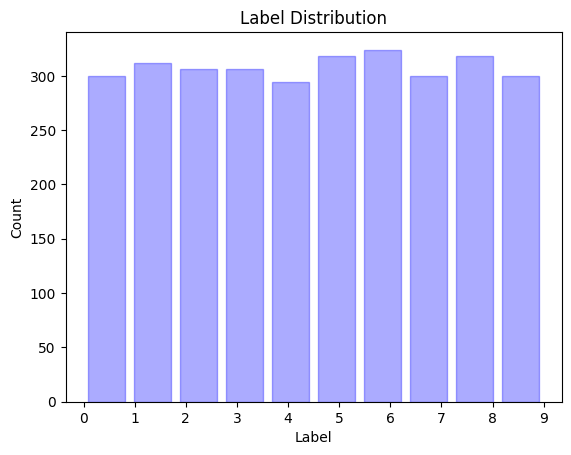

In [ ]:


# Plot a histogram of the labels
plt.hist(y, bins=10, rwidth=0.8, alpha=0.33, color='blue', edgecolor='blue')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.xticks(range(10))  # Assuming you have 10 classes (0-9)
plt.show()


In [ ]:


label_counts = np.bincount(y)
print(label_counts)
print(y.shape)

[300 312 306 306 294 318 324 300 318 300]
(3078,)


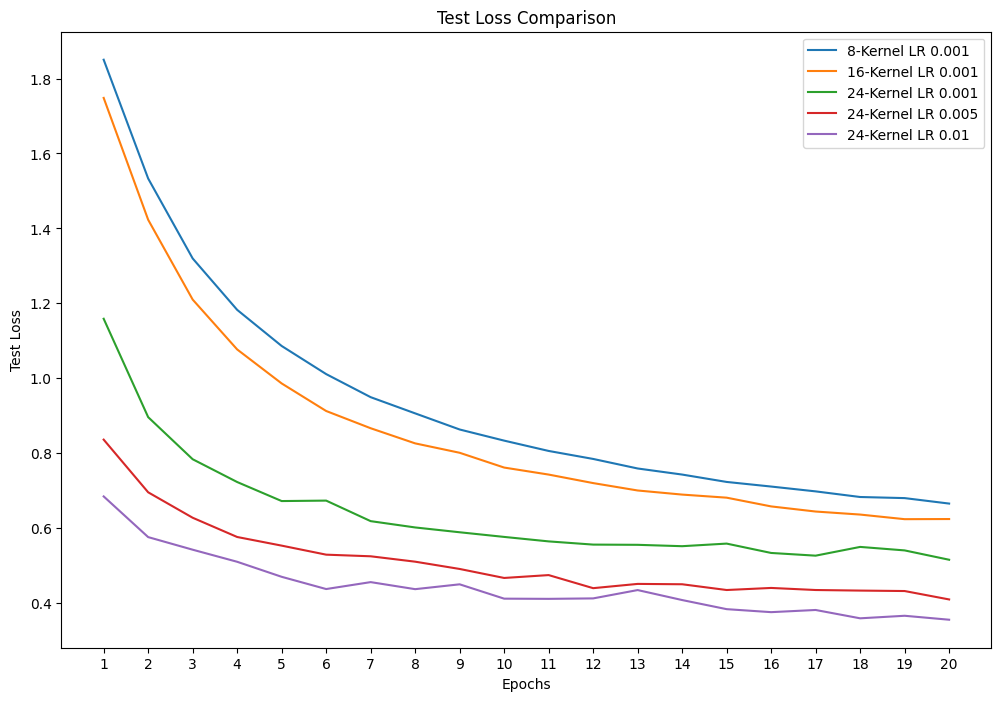

In [ ]:
import matplotlib.pyplot as plt

# Define the test losses for each configuration
test_losses_8_kernel_lr_0_001 = [1.8502896146027334, 1.5331625893372685, 1.3198183859640678, 1.1825879691067103, 1.086168212739968, 1.011117330691523, 0.9494983639282415, 0.9062573398748577, 0.8632141175808065, 0.8334991977250791, 0.8059479769089951, 0.7846151880866337, 0.7591371337955126, 0.742917258085323, 0.7232249274498556, 0.710914679920135, 0.6980187287111164, 0.6830008391429521, 0.6800679544564918, 0.6654653149944715]

test_losses_16_kernel_lr_0_001 = [1.7483693248139804, 1.423064915494892, 1.2100203083897867, 1.0769164503161945, 0.9861756362424651, 0.9125882167903634, 0.8665710829845753, 0.8261714862926461, 0.8010690066164646, 0.7615958530547289, 0.7428779401413068, 0.7201580471665731, 0.7004004421783353, 0.6894542570166959, 0.6812233276476387, 0.6578872538318505, 0.644221293965346, 0.6361440200032893, 0.6238274705085635, 0.6241845899913184]

test_losses_24_kernel_lr_0_001 = [1.158811717838892, 0.8961624889675455, 0.7838185444069777, 0.7229840786129569, 0.6721797966201175, 0.6733884724421887, 0.6185660580220251, 0.60173282150258, 0.5888755100593802, 0.5764705296794577, 0.5645168491156024, 0.5559571084811554, 0.5553652664975224, 0.5516976671647856, 0.5586324498153142, 0.5336410082057482, 0.526418025463597, 0.5497787223226636, 0.5404544378377245, 0.5155087768115182]

test_losses_24_kernel_lr_0_005 = [0.8361664476448855, 0.695544439032893, 0.6276429068215759, 0.5762533331686885, 0.5531988840702944, 0.5290913530493464, 0.5247451935923952, 0.5103653898027956, 0.49092746753414884, 0.466906956553103, 0.4745673678465226, 0.4396509653960807, 0.45103007037659903, 0.45008618375050946, 0.43472629300493826, 0.44025355987385556, 0.43472405501027256, 0.4331979229047639, 0.4319989124150819, 0.40954158079295017]

test_losses_24_kernel_lr_0_01 = [0.6845677297281736, 0.5759492800702799, 0.5423397011395135, 0.5100876121850901, 0.469974814807291, 0.43730674552973675, 0.45579805280397334, 0.43699429125045297, 0.44992932199554936, 0.41164293597461815, 0.4111337516101259, 0.41232773682417606, 0.43459266030455623, 0.4079369538153711, 0.3836309903391387, 0.37562612744144425, 0.3814271073413038, 0.35918563841519324, 0.36597289300730385, 0.3554203942661388]

# Create an array of integers for the x-axis (epochs)
epochs = list(range(1, len(test_losses_8_kernel_lr_0_001) + 1))

plt.figure(figsize=(12, 8))
# Plot the test losses for each configuration
plt.plot(epochs, test_losses_8_kernel_lr_0_001, label='8-Kernel LR 0.001')
plt.plot(epochs, test_losses_16_kernel_lr_0_001, label='16-Kernel LR 0.001')
plt.plot(epochs, test_losses_24_kernel_lr_0_001, label='24-Kernel LR 0.001')
plt.plot(epochs, test_losses_24_kernel_lr_0_005, label='24-Kernel LR 0.005')
plt.plot(epochs, test_losses_24_kernel_lr_0_01, label='24-Kernel LR 0.01')

# Add labels and legend
plt.xlabel('Epochs')
plt.ylabel('Test Loss')
plt.title('Test Loss Comparison')
plt.legend()

# Set the x-axis ticks to display only integers
plt.xticks(epochs)

# Show the plot
plt.show()


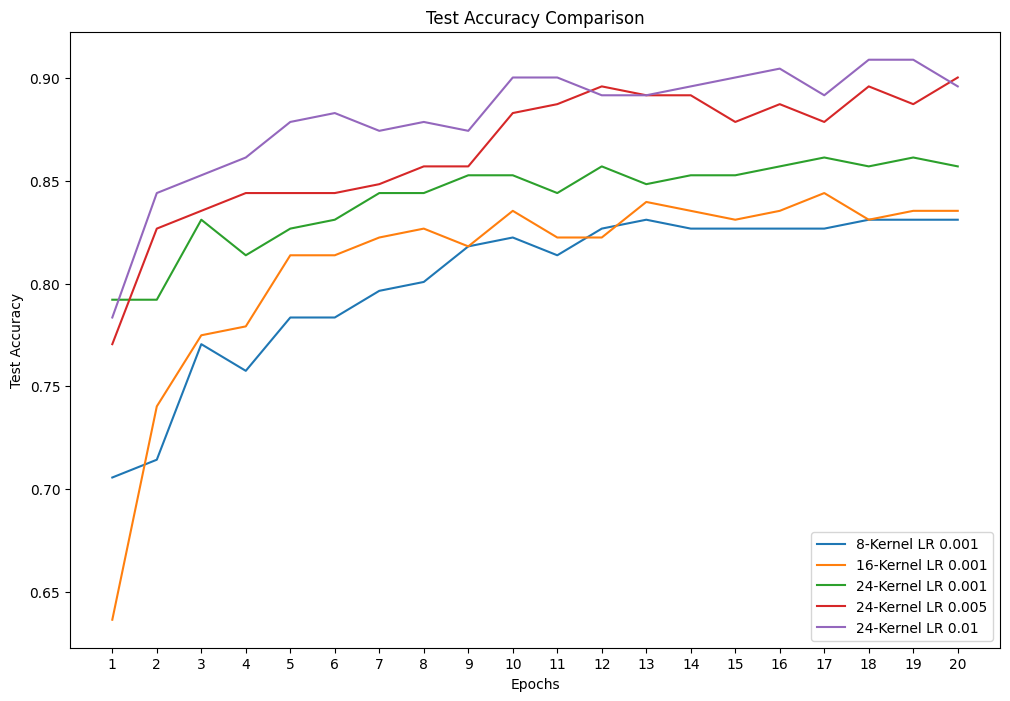

In [ ]:
import matplotlib.pyplot as plt

# Define the test accuracies for each configuration
test_accuracy_8_kernel_lr_0_001 = [0.7056277056277056, 0.7142857142857143, 0.7705627705627706, 0.7575757575757576, 0.7835497835497836, 0.7835497835497836, 0.7965367965367965, 0.8008658008658008, 0.8181818181818182, 0.8225108225108225, 0.8138528138528138, 0.8268398268398268, 0.8311688311688312, 0.8268398268398268, 0.8268398268398268, 0.8268398268398268, 0.8268398268398268, 0.8311688311688312, 0.8311688311688312, 0.8311688311688312]

test_accuracy_16_kernel_lr_0_001 = [0.6363636363636364, 0.7402597402597403, 0.7748917748917749, 0.7792207792207793, 0.8138528138528138, 0.8138528138528138, 0.8225108225108225, 0.8268398268398268, 0.8181818181818182, 0.8354978354978355, 0.8225108225108225, 0.8225108225108225, 0.8398268398268398, 0.8354978354978355, 0.8311688311688312, 0.8354978354978355, 0.8441558441558441, 0.8311688311688312, 0.8354978354978355, 0.8354978354978355]

test_accuracy_24_kernel_lr_0_001 = [0.7922077922077922, 0.7922077922077922, 0.8311688311688312, 0.8138528138528138, 0.8268398268398268, 0.8311688311688312, 0.8441558441558441, 0.8441558441558441, 0.8528138528138528, 0.8528138528138528, 0.8441558441558441, 0.8571428571428571, 0.8484848484848485, 0.8528138528138528, 0.8528138528138528, 0.8571428571428571, 0.8614718614718615, 0.8571428571428571, 0.8614718614718615, 0.8571428571428571]

test_accuracy_24_kernel_lr_0_005 = [0.7705627705627706, 0.8268398268398268, 0.8354978354978355, 0.8441558441558441, 0.8441558441558441, 0.8441558441558441, 0.8484848484848485, 0.8571428571428571, 0.8571428571428571, 0.8831168831168831, 0.8874458874458875, 0.8961038961038961, 0.8917748917748918, 0.8917748917748918, 0.8787878787878788, 0.8874458874458875, 0.8787878787878788, 0.8961038961038961, 0.8874458874458875, 0.9004329004329005]

test_accuracy_24_kernel_lr_0_01 = [0.7835497835497836, 0.8441558441558441, 0.8528138528138528, 0.8614718614718615, 0.8787878787878788, 0.8831168831168831, 0.8744588744588745, 0.8787878787878788, 0.8744588744588745, 0.9004329004329005, 0.9004329004329005, 0.8917748917748918, 0.8917748917748918, 0.8961038961038961, 0.9004329004329005, 0.9047619047619048, 0.8917748917748918, 0.9090909090909091, 0.9090909090909091, 0.8961038961038961]

# Create an array of integers for the x-axis (epochs)
epochs = list(range(1, len(test_accuracy_8_kernel_lr_0_001) + 1))

plt.figure(figsize=(12, 8))
# Plot the test accuracies for each configuration
plt.plot(epochs, test_accuracy_8_kernel_lr_0_001, label='8-Kernel LR 0.001')
plt.plot(epochs, test_accuracy_16_kernel_lr_0_001, label='16-Kernel LR 0.001')
plt.plot(epochs, test_accuracy_24_kernel_lr_0_001, label='24-Kernel LR 0.001')
plt.plot(epochs, test_accuracy_24_kernel_lr_0_005, label='24-Kernel LR 0.005')
plt.plot(epochs, test_accuracy_24_kernel_lr_0_01, label='24-Kernel LR 0.01')

# Add labels and legend
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy Comparison')
plt.legend()

# Set the x-axis ticks to display only integers
plt.xticks(epochs)

# Show the plot
plt.show()
